In [388]:
#/usr/bin/python3.8
# Use jupyter notebook with python 3+
"""
Auth : Al Sabawi
Date: Mar 14, 2020
Last Update : Mar 21, 2020
"""
# Need the following libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Markdown as md
from IPython.display import display, HTML


In [389]:
# Set the region as spelled in the Johns Hupkins Center file below
region = 'Kuwait' #'Korea, South' 'Kuwait'  'United Kingdom' 'China' 'Italy' 'France' 'Canada' 'Australia'

In [390]:
# Set regions list
regions_list = ['China','Italy','US','Germany','Spain','Canada','France','Korea, South','United Kingdom']
colors = ['blue','green','purple', 'cyan','magenta','black','#8c564b','blueviolet', 'teal']  
pd.set_option("display.max_rows", None, "display.max_columns", None)
def return_region():
    return region


=>initcell
##### Analysis by Al Sabawi
##### Date: Mar 14, 2020
##### Last Update : Apr 6, 2020
# Region : **{{region}}**  

In [391]:
## Some Helper Functions
import io
import requests

display(md('<font size=6><strong>{}</strong></font><br/>'.format(region)))
def FindLocalMinMax(df, colname, n):
    # Find local peaks
    df['min'] = df.iloc[argrelextrema(df[colname].values,
                                      np.less_equal,
                                      order=n)[0]][colname]
    df['max'] = df.iloc[argrelextrema(df[colname].values,
                                      np.greater_equal,
                                      order=n)[0]][colname]

    return df

def GetCSVFromURL(filename):
    base = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
    url = base+filename
    s=requests.get(url).content
    c=pd.read_csv(url,encoding = 'utf-8')
    return c

<font size=6><strong>Kuwait</strong></font><br/>

## Data Source

#### Johns Hupkins Whiting School of Engineering COVID-19 Data Repository at https://github.com/CSSEGISandData

## Download the data to your computer daily

In [392]:
## Download the latest data file from:
## https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series
## File name "time_series_19-covid-Confirmed.csv"  for all confirmed cases in the world by region
## *** DOWNLOAD to local directory ***
confirmed_filename = 'time_series_covid19_confirmed_global.csv'
recovered_filename = 'time_series_covid19_recovered_global.csv'
deaths_filename = 'time_series_covid19_deaths_global.csv'

## If you are reading from files downloaded to local directory, uncomment the lines below
#df_confirmed = pd.read_csv(confirmed_filename)
#df_recovered = pd.read_csv(recovered_filename)
#df_deaths = pd.read_csv(deaths_filename)

## If the following 3 lines of code are no longer commented out, then
## you DON'T NEED to download the 3 files to local directory. 
df_confirmed = GetCSVFromURL(confirmed_filename)
df_recovered = GetCSVFromURL(recovered_filename)
df_deaths = GetCSVFromURL(deaths_filename)

## Separate the dates to use as an index later
dates = df_confirmed.columns[4:]
dates_recovered = df_recovered.columns[4:]

## Filter for a specific region data only
usa = df_confirmed[df_confirmed['Country/Region'].values == region].copy(
    deep=True)
usa_recovered = df_recovered[df_recovered['Country/Region'].values ==
                             region].copy(deep=True)
usa_deaths = df_deaths[df_deaths['Country/Region'].values == region].copy(
    deep=True)

usad = usa[dates].copy(deep=True)
last_date = usa[dates].columns[-1]

## Put the US data into a DataFrame Series and give it a name
colname = 'Confirmed ' + region + ' COVID-19 Cases'
colname_recovered = 'Recovered in ' + region + ' from COVID-19 Cases'
colname_deaths = 'Deaths in ' + region + ' from COVID-19 Cases'

us_df_cumulative = pd.DataFrame(usa[dates].sum(), columns=[colname])
us_df_cumulative['dates'] = dates
us_df_recovered_cum = pd.DataFrame(usa_recovered[dates_recovered].sum(),
                                   columns=[colname_recovered])
us_df_deaths_cum = pd.DataFrame(usa_deaths[dates].sum(),
                                columns=[colname_deaths])

# Check: These 2 following prints should give the same number on same Last Dates data is collected
#print(last_date, usad[last_date].sum())
#print(us_df_cumulative[-1:])

## Confirmed COVID-19 Cases Linear Charts

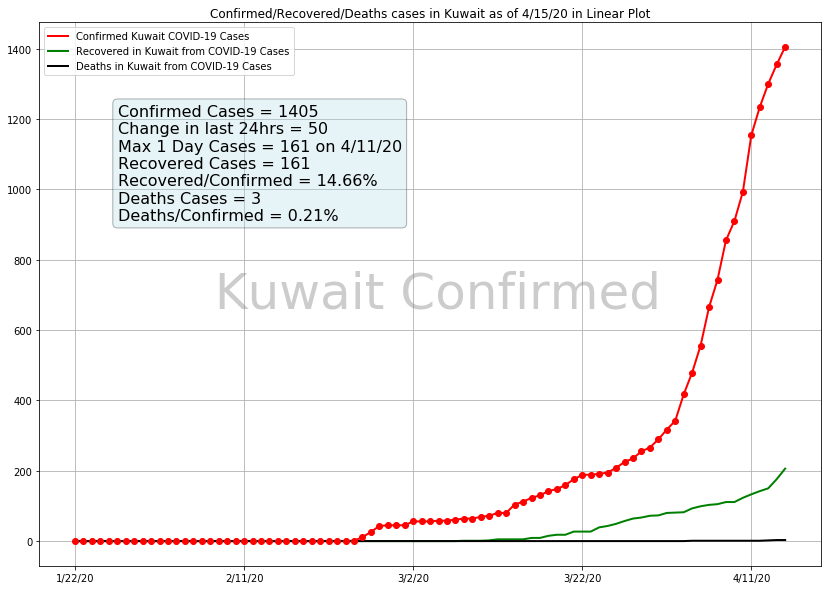

In [393]:
## Plot the raw data (not logarithmic)
fig, ax = plt.subplots(figsize=(14, 10))
#us_df = pd.DataFrame(usa[dates].sum(), columns=[colname])

us_df_cumulative.plot(ax=ax,
                      c='red',
                      lw=2,
                      title='Confirmed/Recovered/Deaths cases in ' + region +
                      ' as of ' + str(us_df_cumulative.index[-1]) +
                      ' in Linear Plot')
us_df_recovered_cum.plot(ax=ax, c='green', lw=2)
us_df_deaths_cum.plot(ax=ax, c='black', lw=2)

ax.plot(us_df_cumulative[colname], 'o', c='red', lw=8)

last_conf = us_df_cumulative[colname][-1:][0]
last_recov = us_df_recovered_cum[colname_recovered][-1:][0]
last_death = us_df_deaths_cum[colname_deaths][-1:][0]
last_conf_change = us_df_cumulative[colname][-1:][0] - us_df_cumulative[
    colname][-2:][0]
max_1day_cases = us_df_cumulative[colname].diff(1).max()
max_date = us_df_cumulative[colname].diff(1).idxmax(axis=0)

textstr = '\n'.join(
    (r'Confirmed Cases = %.0f' % (last_conf, ),
     r'Change in last 24hrs = %.0f' % (last_conf_change, ),
     r'Max 1 Day Cases = %.0f' % (max_1day_cases, ) + ' on '+max_date,
     r'Recovered Cases = %.0f' % (max_1day_cases, ),
     r'Recovered/Confirmed = %.2f%%' % (last_recov * 100 / last_conf, ),
     r'Deaths Cases = %.0f' % (last_death, ),
     r'Deaths/Confirmed = %.2f%%' % (last_death * 100 / last_conf, )))

props = dict(boxstyle='round', facecolor='lightblue', alpha=0.3)
ax.text(0.1,
        0.85,
        textstr,
        transform=ax.transAxes,
        fontsize=16,
        fontfamily='sans-serif',
        verticalalignment='top',
        bbox=props)

ax.text(0.5,
        0.5,
        ' '+region + ' Confirmed',
        horizontalalignment='center',
        color='gray',
        fontsize=50,
        alpha=0.4,
        verticalalignment='center',
        transform=ax.transAxes)

ax.grid(True, which="both")

## Change Confirmed COVID-19 Cases Linear Charts

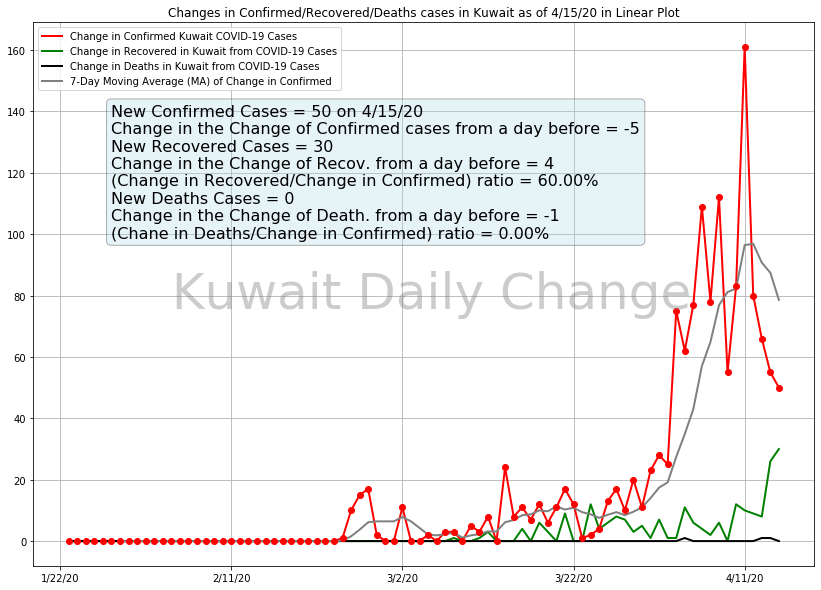

In [394]:
## Plot the raw data (not logarithmic)
fig, ax = plt.subplots(figsize=(14, 10))

us_df_cumulative[colname].diff(1).plot(ax=ax,c='red',lw=2, 
                              title='Changes in Confirmed/Recovered/Deaths cases in ' + region +' as of ' + str(us_df_cumulative.index[-1]) +' in Linear Plot')
us_df_recovered_cum[colname_recovered].diff(1).plot(ax=ax, c='green', lw=2)
us_df_deaths_cum[colname_deaths].diff(1).plot(ax=ax, c='black', lw=2)

last_conf = us_df_cumulative[colname].diff(1)[-1:][0]
last_recov = us_df_recovered_cum[colname_recovered].diff(1)[-1:][0]
last_death = us_df_deaths_cum[colname_deaths].diff(1)[-1:][0]
last_conf_change = us_df_cumulative[colname].diff(1)[-1:][0] - us_df_cumulative[
    colname].diff(1)[-2:][0]

last_recov_change = us_df_recovered_cum[colname_recovered].diff(1)[-1:][0] - us_df_recovered_cum[
    colname_recovered].diff(1)[-2:][0]


last_death_change = us_df_deaths_cum[colname_deaths].diff(1)[-1:][0] - us_df_deaths_cum[
    colname_deaths].diff(1)[-2:][0]


MAperiod = 7
TheCurveMA_df = pd.DataFrame()
TheCurveMA_df['7-Day Moving Average (MA)'] = us_df_cumulative[colname].diff(1).rolling(
    window=MAperiod).mean()

TheCurveMA_df.plot(
    ax=ax,
    c='gray',
    lw=2)


ax.plot(us_df_cumulative[colname].diff(1), 'o', c='red', lw=8,label='_Hidden',)


textstr = '\n'.join(
    (r'New Confirmed Cases = %.0f on ' % (last_conf, ) +  str(us_df_cumulative.index[-1]) ,
     r'Change in the Change of Confirmed cases from a day before = %.0f' % (last_conf_change, ),
     r'New Recovered Cases = %.0f' % (last_recov, ),
     r'Change in the Change of Recov. from a day before = %.0f' % (last_recov_change, ),
     r'(Change in Recovered/Change in Confirmed) ratio = %.2f%%' % (last_recov * 100 / last_conf, ),
     r'New Deaths Cases = %.0f' % (last_death, ),
     r'Change in the Change of Death. from a day before = %.0f' % (last_death_change, ),
     r'(Chane in Deaths/Change in Confirmed) ratio = %.2f%%' % (last_death * 100 / last_conf, )))

props = dict(boxstyle='round', facecolor='lightblue', alpha=0.3)
ax.text(0.1,
        0.85,
        textstr,
        transform=ax.transAxes,
        fontsize=16,
        fontfamily='sans-serif',
        verticalalignment='top',
        bbox=props)

ax.text(0.5,
        0.5,
        ' '+region + ' Daily Change',
        horizontalalignment='center',
        color='gray',
        fontsize=50,
        alpha=0.4,
        verticalalignment='center',
        transform=ax.transAxes)

ax.grid(True, which="both")
ax.legend(['Change in '+colname,'Change in '+colname_recovered, 'Change in '+colname_deaths, '7-Day Moving Average (MA) of Change in Confirmed'])
plt.show()

## Confirmed COVID-19 Cases Logarithmic Charts

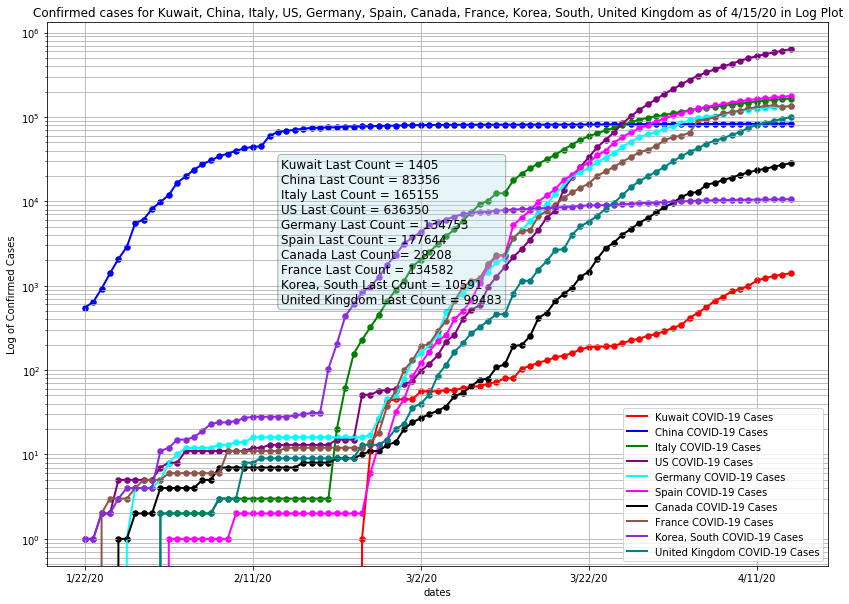

In [395]:
## Plot the raw data (logarithmic)

if region not in regions_list:
    regions_list.insert(0, region)
    colors.insert(0, 'red')

list2string = ', '.join([str(elem) for elem in regions_list])
title = 'Confirmed cases for ' + list2string + ' as of ' + str(
    us_df_cumulative.index[-1]) + ' in Log Plot'
text_strings = []
fig, ax = plt.subplots(figsize=(14, 10))
#fig.suptitle(title,size=24)
i = 0
for r in regions_list:
    colname2 = r + ' COVID-19 Cases'

    df1 = df_confirmed[df_confirmed['Country/Region'].values == r].copy(
        deep=True)

    df2 = pd.DataFrame(df1[dates].sum(), columns=[colname2])
    df2['dates'] = dates
    df2[colname2].plot(ax=ax, logy=True, c=colors[i], lw=2, title=title)
    df2.plot.scatter(ax=ax,
                     logy=True,
                     c=colors[i],
                     x='dates',
                     y=colname2,
                     lw=2)
    text_strings.append(regions_list[i] + ' Last Count = ' +
                        str(int(df2[colname2][-1:][0])))
    i = i + 1

textstr = '\n'.join([str(elem) for elem in text_strings])
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.3)
ax.text(0.3,
        0.75,
        textstr,
        transform=ax.transAxes,
        fontsize=12,
        fontfamily='sans-serif',
        verticalalignment='top',
        bbox=props)

plt.ylabel('Log of Confirmed Cases')
ax.legend()
ax.grid(True, which="both")
plt.show()

## Trajectory Curves

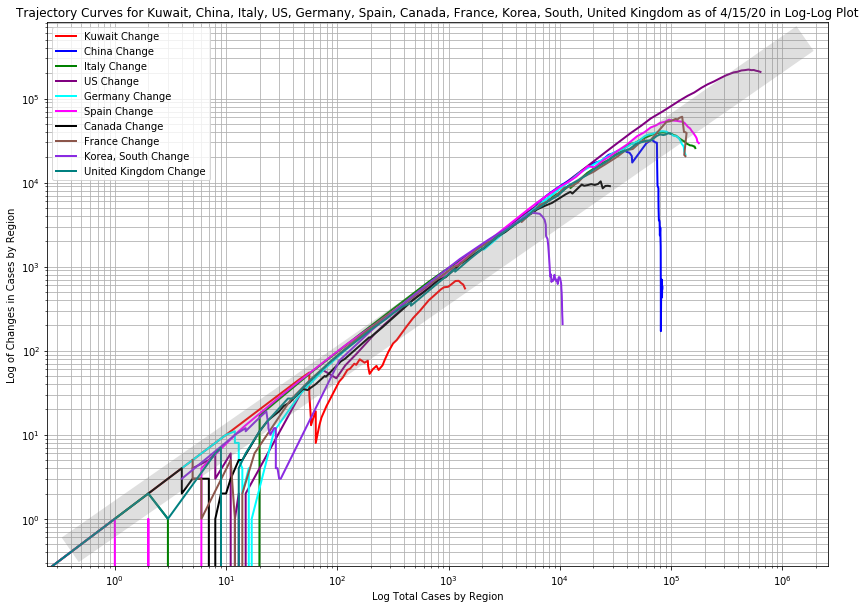

In [396]:
## Plot the raw data (logarithmic)

if region not in regions_list:
    regions_list.insert(0, region)
    colors.insert(0, 'red')

list2string = ', '.join([str(elem) for elem in regions_list])
title = 'Trajectory Curves for ' + list2string + ' as of ' + str(
    us_df_cumulative.index[-1]) + ' in Log-Log Plot'
text_strings = []
fig, ax = plt.subplots(figsize=(14, 10))

#fig.suptitle(title,size=24)
i = 0
for r in regions_list:
    colname2 = r + ' Total COVID-19 Cases'

    df1 = df_confirmed[df_confirmed['Country/Region'].values == r].copy(
        deep=True)
    df_cumulativelist = pd.DataFrame(df1[dates].sum(), columns=[colname2])

    df_traj = pd.DataFrame()
    diff_df = df_cumulativelist.diff(7)

    df_traj[r + ' Change'] = diff_df[colname2].values

    df_traj[colname2] = df_cumulativelist[colname2].values

    df_traj = df_traj.set_index(colname2)
    df_traj.dropna(inplace=True)

    df_traj.plot(ax=ax, loglog=True, c=colors[i], lw=2, title=title)
    #df_traj.plot.scatter(ax=ax,logy=True,c=colors[i],x=colname2,y='Change' ,lw=2)
    #text_strings.append(regions_list[i] + ' Last Count = ' + str(int(df2[colname2][-1:][0])))
    i = i + 1

textstr = '\n'.join([str(elem) for elem in text_strings])
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.3)
ax.text(0.3,
        0.75,
        textstr,
        transform=ax.transAxes,
        fontsize=12,
        fontfamily='sans-serif',
        verticalalignment='top',
        bbox=props)

plt.ylabel('Log of Changes in Cases by Region')
plt.xlabel('Log Total Cases by Region')
#ax.legend()
ax.grid(True, which="both")

ax.loglog(ax.get_xlim(),
          ax.get_ylim(),
          linestyle='-',
          c='gray',
          linewidth=30,
          dash_capstyle='round',
          alpha=.25)
plt.show()

## Death Rates Camparison Charts (Linear)

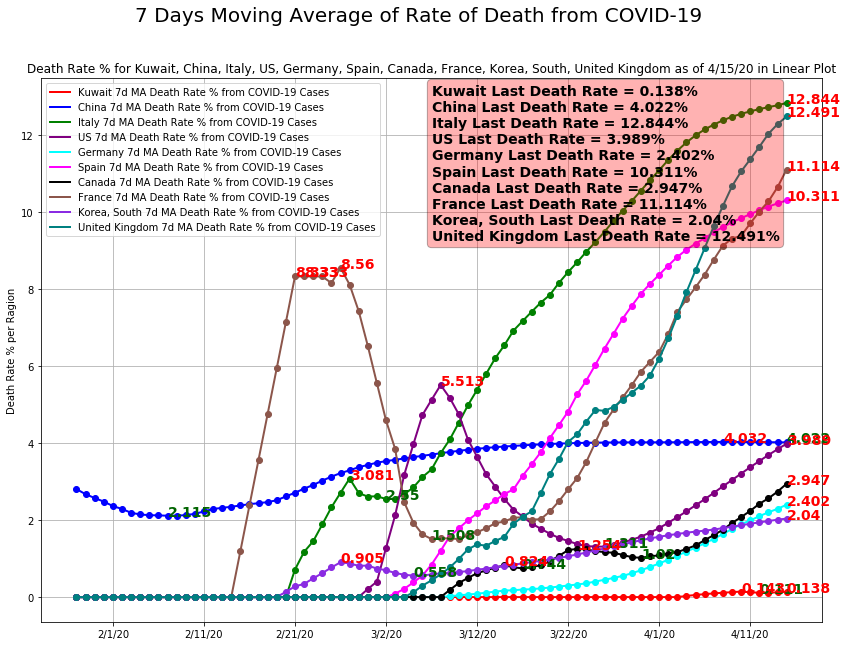

,7 Days Moving Average of Death Rate
Regions,
Italy,12.844%
United Kingdom,12.491%
France,11.114%
Spain,10.311%
China,4.022%
US,3.989%
Canada,2.947%
Germany,2.402%
"Korea, South",2.04%


In [397]:
## Plot theDeath Rates
if region not in regions_list:
    regions_list.insert(0, region)
    colors.insert(0, 'red')

list2string = ', '.join([str(elem) for elem in regions_list])
title = 'Death Rate % for ' + list2string + ' as of ' + str(
    us_df_cumulative.index[-1]) + ' in Linear Plot'
text_strings = []
fig, ax = plt.subplots(figsize=(14, 10))

death_rates = []

i = 0
MAperiod = 7
## Plot all the regions on one chart
for r in regions_list:
    colname3 = r + ' ' + str(
        MAperiod) + 'd MA Death Rate % from COVID-19 Cases'

    deaths_count = df_deaths[df_deaths['Country/Region'].values == r].copy(
        deep=True)
    confirmed_count = df_confirmed[df_confirmed['Country/Region'].values ==
                                   r].copy(deep=True)

    df_confirmed_cum = pd.DataFrame(confirmed_count[dates].sum(),
                                    columns=[colname3])
    df_deaths_cum = pd.DataFrame(deaths_count[dates].sum(), columns=[colname3])

    ## Calculate death rate in %
    df2 = pd.DataFrame(df_deaths_cum * 100 / df_confirmed_cum,
                       columns=[colname3])
    df2[colname3] = df2[colname3].fillna(0)
    df2['dates'] = dates

    ## calculate & plot the MAperiod Moving Average
    df2[colname3].rolling(window=MAperiod).mean().plot(ax=ax,
                                                       logy=False,
                                                       c=colors[i],
                                                       lw=2,
                                                       title=title)

    ## Plot the dots
    ax.plot(df2[colname3].rolling(window=MAperiod).mean(),
            'o',
            c=colors[i],
            lw=8)

    ## Create the Text box with data
    text_strings.append(regions_list[i] + ' Last Death Rate = ' + str(
        np.round(df2[colname3].rolling(window=MAperiod).mean()[-1:][0], 3)) +
                        '%')

    death_rates.append(
        str(np.round(df2[colname3].rolling(window=MAperiod).mean()[-1:][0],
                     3)))

    ## Prepare the DataFrames Minima and Maxima for marking the charts
    df2[colname3 +
        '_MA'] = df2[colname3].rolling(window=MAperiod).mean().dropna()

    ## Call FindLocalMinMax() function avove to calulate minimas and maximas into a DF
    maxmin_window = 3
    minmax_df = FindLocalMinMax(df2, colname3 + '_MA', maxmin_window)

    ## Clean up the min/max data frames
    cleanmin_df = pd.DataFrame(minmax_df['min'].dropna(), columns=['min'])
    cleanmin_df['dates'] = minmax_df['min'].dropna().index
    cleanmin_df = cleanmin_df.set_index('dates')

    cleanmax_df = pd.DataFrame(minmax_df['max'].dropna(), columns=['max'])
    cleanmax_df['dates'] = minmax_df['max'].dropna().index
    cleanmax_df = cleanmax_df.set_index('dates')

    ## Write them on the chart
    #print('Minimas')
    style = dict(size=14, color='darkgreen', weight='bold')
    for item in range(len(cleanmin_df['min'])):
        if cleanmin_df['min'].values[item] > 0.0:
            ax.text(cleanmin_df['min'].index.values[item],
                    cleanmin_df['min'].values[item],
                    str(np.round(cleanmin_df['min'].values[item], 3)), **style)
            #print(cleanmin_df['min'].index.values[item] , cleanmin_df['min'].values[item] )

    #print('Maximas')
    style = dict(size=14, color='red', weight='bold')
    for item in range(len(cleanmax_df['max'])):
        if cleanmax_df['max'].values[item] > 0.0:
            ax.text(cleanmax_df['max'].index.values[item],
                    cleanmax_df['max'].values[item],
                    str(np.round(cleanmax_df['max'].values[item], 3)), **style)
            #print(cleanmax_df['max'].index.values[item] , cleanmax_df['max'].values[item] )

    i = i + 1

## Dress up the chart
fig.suptitle(str(MAperiod) +
             ' Days Moving Average of Rate of Death from COVID-19',
             size=20)
textstr = '\n'.join([str(elem) for elem in text_strings])
props = dict(boxstyle='round', facecolor='red', alpha=0.3)
ax.text(0.50,
        0.99,
        textstr,
        transform=ax.transAxes,
        fontsize=14,
        fontweight='heavy',
        fontfamily='sans-serif',
        verticalalignment='top',
        bbox=props)

plt.ylabel('Death Rate % per Ragion')
ax.legend()
ax.grid(True, which="both")
plt.show()
#print(death_rates)
#print(regions_list)

death_rate_countries = pd.DataFrame()
death_rate_countries['Regions'] = regions_list
death_rate_countries[str(MAperiod)+' Days Moving Average of Death Rate'] = [
    float(i) for i in death_rates
]
death_rate_countries.set_index('Regions', inplace=True)
death_rate_countries.sort_values(by=str(MAperiod)+' Days Moving Average of Death Rate',
                                 ascending=False,
                                 inplace=True)
death_rate_countries[str(MAperiod)+' Days Moving Average of Death Rate'] = [
    str(i) + '%'
    for i in death_rate_countries[str(MAperiod)+' Days Moving Average of Death Rate'].
    values.tolist()
]
death_rate_countries

=>initcell
## The Active Curve for {{region}}

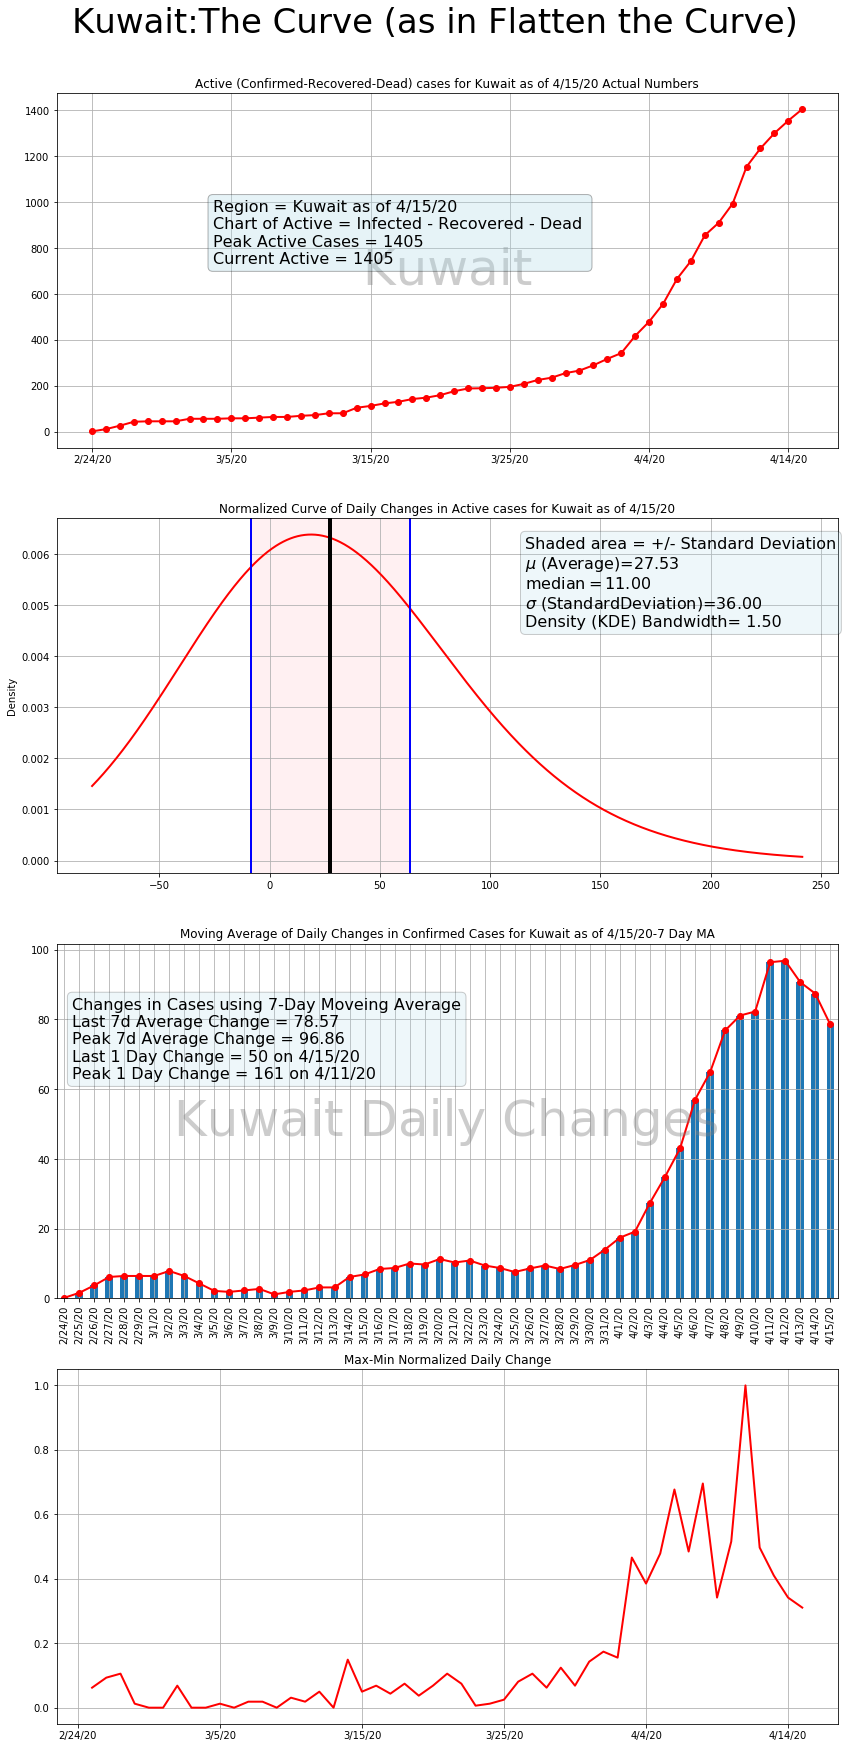

In [398]:
## The Curve
TheCurve_df = pd.DataFrame()
#us_df_cumulative = pd.DataFrame(usa[dates].sum(), columns=[colname])
#TheCurve_df = us_df_cumulative[colname] - us_df_recovered_cum[colname_recovered] - us_df_deaths_cum[colname_deaths]
#TheCurve_df = us_df_cumulative[colname] - us_df_deaths_cum[colname_deaths]

TheCurve_df['cum'] = us_df_cumulative[us_df_cumulative[colname] > 0][colname].copy(deep=True)
#TheCurve_df['cum'] = us_df_cumulative[colname].copy(deep=True)

fig, ax = plt.subplots(4, 1, figsize=(14, 30))

#us_df_cumulative_no0 = us_df_cumulative[colname].diff(1).copy(deep=True)
TheCurve_df['cum'].plot(ax=ax[0],
                        c='red',
                        lw=2,
                        title='Active (Confirmed-Recovered-Dead) cases for ' +
                        region + ' as of ' + str(us_df_cumulative.index[-1]) +
                        ' Actual Numbers')
ax[0].plot(TheCurve_df['cum'], 'o', c='red', lw=8)
ax[0].grid(True, which="both")

peak = TheCurve_df['cum'].max()
last_sick = TheCurve_df['cum'][-1]

textstr = '\n'.join((r'Region = %s as of %s' % (
    region,
    str(us_df_cumulative.index[-1]),
), r'Chart of Active = Infected - Recovered - Dead ',
                     r'Peak Active Cases = %.0f' % (peak, ),
                     r'Current Active = %.0f' % (last_sick, )))

props = dict(boxstyle='round', facecolor='lightblue', alpha=0.3)

ax[0].text(0.5,
        0.5,
        ' '+region + ' ',
        horizontalalignment='center',
        color='gray',
        fontsize=50,
        alpha=0.4,
        verticalalignment='center',
        transform=ax[0].transAxes)

_ = ax[0].text(0.2,
               0.7,
               textstr,
               transform=ax[0].transAxes,
               fontsize=16,
               fontfamily='sans-serif',
               verticalalignment='top',
               bbox=props)

## Plot the normal Probability Density Function (PDF) curve
kde_bandwidth = 1.50
TheCurve_diff_df = TheCurve_df['cum'].diff(1)

## Normalized Daily Changes by Mean and Max-Min 
normalized_df1=(TheCurve_diff_df-TheCurve_diff_df.min())/(TheCurve_diff_df.max()-TheCurve_diff_df.min())
normalized_df1.plot(ax=ax[3],c='red',lw=2,title='Max-Min Normalized Daily Change')
ax[3].grid(True, which="both")

#normalized_df2=(TheCurve_diff_df-TheCurve_diff_df.mean())/TheCurve_diff_df.std()
#normalized_df1.plot(ax=ax[4],c='red',lw=2,title='Mean Normalized Daily Change')
#ax[4].grid(True, which="both")

TheCurve_diff_df.plot.kde(
    bw_method=kde_bandwidth,
    ax=ax[1],
    c='red',
    lw=2,
    title='Normalized Curve of Daily Changes in Active cases for ' + region +
    ' as of ' + str(us_df_cumulative.index[-1]) + '')
ax[1].grid(True, which="both")

std_div = TheCurve_diff_df.std()
median = TheCurve_diff_df.median()
mean = TheCurve_diff_df.mean()

ax[1].axvline(mean, lw=4, c='black')
ax[1].axvline(mean - std_div, lw=2, c='blue')
ax[1].axvline(mean + std_div, lw=2, c='blue')
ax[1].axvspan(mean - std_div, mean + std_div, color='lightpink', alpha=.2)

textstr = '\n'.join((r'Shaded area = +/- Standard Deviation',
                     r'$\mu$ (Average)=%.2f' % (mean, ),
                     r'$\mathrm{median}=%.2f$' % (median, ),
                     r'$\sigma$ (StandardDeviation)=%.2f' % (std_div, ),
                     r'Density (KDE) Bandwidth= %.2f' % (kde_bandwidth)))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.2)

# place a text box in upper left in axes coords
_ = ax[1].text(0.6,
               0.95,
               textstr,
               transform=ax[1].transAxes,
               fontsize=16,
               fontfamily='sans-serif',
               verticalalignment='top',
               bbox=props)

plt.suptitle(region + ':The Curve (as in Flatten the Curve)',
             fontsize=34,
             y=0.92)

ChangePeriod = 1
MAperiod = 7
TheCurve_df['MA'] = us_df_cumulative[colname].diff(ChangePeriod).rolling(
    window=MAperiod).mean(
    )  ##TheCurve_df.diff(1) ## .rolling(window=period).mean()

TheCurve_df['MA'].plot(
    ax=ax[2],
    c='red',
    lw=2,
    title='Moving Average of Daily Changes in Confirmed Cases for ' + region +
    ' as of ' + str(us_df_cumulative.index[-1]) + '-' + str(MAperiod) +
    ' Day MA')

TheCurve_df['MA'].plot.bar(ax=ax[2])
#us_df_cumulative[colname].diff(ChangePeriod).plot(ax=ax[2],c='gray',lw=3)

#ax[2].legend()
last_1day_change = int(round(us_df_cumulative[colname].diff(ChangePeriod)[-1]))
peak_1day_change = int(
    round(us_df_cumulative[colname].diff(ChangePeriod).max()))
peak_1day_date = us_df_cumulative[colname].diff(ChangePeriod).idxmax(axis=0)
last_change = round(TheCurve_df['MA'][-1:][0], 2)
peak_change = round(TheCurve_df['MA'].max(), 2)

ax[2].plot(TheCurve_df['MA'], 'o', c='red', lw=8)
ax[2].grid(True, which="both")

ax[2].text(0.5,
           0.5,
           region + ' Daily Changes',
           horizontalalignment='center',
           color='gray',
           fontsize=50,
           alpha=0.4,
           verticalalignment='center',
           transform=ax[2].transAxes)

textstr = '\n'.join(
    (r'Changes in Cases using ' + str(MAperiod) + '-Day Moveing Average',
     r'Last 7d Average Change = ' + str(last_change),
     r'Peak 7d Average Change = ' + str(peak_change), r'Last 1 Day Change = ' +
     str(last_1day_change) + ' on ' + str(us_df_cumulative.index[-1]),
     r'Peak 1 Day Change = ' + str(peak_1day_change) + ' on ' +
     peak_1day_date))

props = dict(boxstyle='round', facecolor='lightblue', alpha=0.2)
#ax[2].tick_params(labelrotation=45)

_ = ax[2].text(0.02,
               0.85,
               textstr,
               transform=ax[2].transAxes,
               fontsize=16,
               fontfamily='sans-serif',
               verticalalignment='top',
               bbox=props)


plt.show()

=>initcell
## The Change Curve for {{region}}

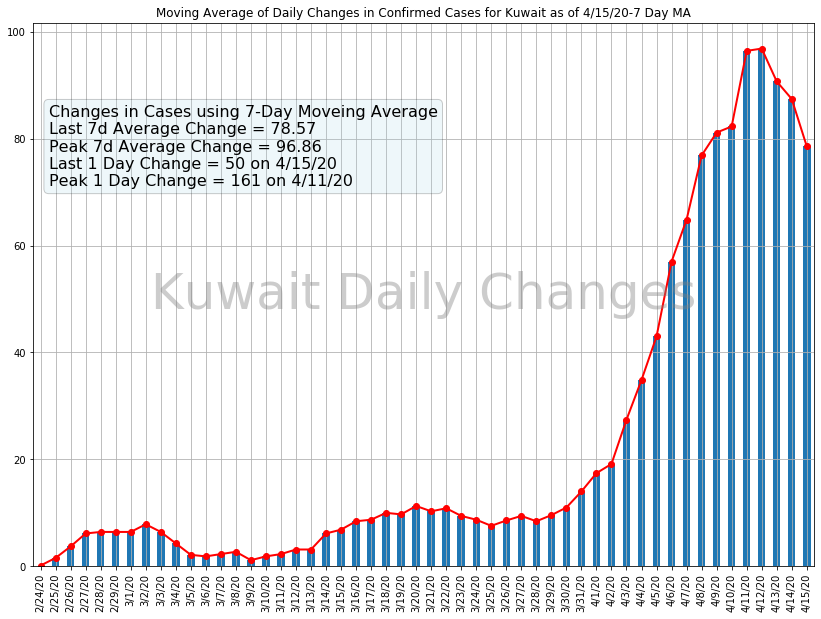

In [399]:
## The Change Curve

us_df_cumulative = pd.DataFrame(usa[dates].sum(), columns=[colname])
TheCurve_df['cum'] = us_df_cumulative[colname]
#print(TheCurve_df)
fig, ax = plt.subplots(figsize=(14, 10))
ChangePeriod = 1
MAperiod = 7
TheCurve_df['MA'] = us_df_cumulative[colname].diff(ChangePeriod).rolling(
    window=MAperiod).mean()

TheCurve_df['MA'].plot(
    ax=ax,
    c='red',
    lw=2,
    title='Moving Average of Daily Changes in Confirmed Cases for ' + region +
    ' as of ' + str(us_df_cumulative.index[-1]) + '-' + str(MAperiod) +
    ' Day MA')

TheCurve_df['MA'].plot.bar(ax=ax)
#us_df_cumulative[colname].diff(ChangePeriod).plot(ax=ax[2],c='gray',lw=3)

#ax[2].legend()
last_1day_change = int(round(us_df_cumulative[colname].diff(ChangePeriod)[-1]))
peak_1day_change = int(
    round(us_df_cumulative[colname].diff(ChangePeriod).max()))
peak_1day_date = us_df_cumulative[colname].diff(ChangePeriod).idxmax(axis=0)
last_change = round(TheCurve_df['MA'][-1:][0], 2)
peak_change = round(TheCurve_df['MA'].max(), 2)

ax.plot(TheCurve_df['MA'], 'o', c='red', lw=8)
ax.grid(True, which="both")

ax.text(0.5,
        0.5,
        region + ' Daily Changes',
        horizontalalignment='center',
        color='gray',
        fontsize=50,
        alpha=0.4,
        verticalalignment='center',
        transform=ax.transAxes)

textstr = '\n'.join(
    (r'Changes in Cases using ' + str(MAperiod) + '-Day Moveing Average',
     r'Last 7d Average Change = ' + str(last_change),
     r'Peak 7d Average Change = ' + str(peak_change), r'Last 1 Day Change = ' +
     str(last_1day_change) + ' on ' + str(us_df_cumulative.index[-1]),
     r'Peak 1 Day Change = ' + str(peak_1day_change) + ' on ' +
     peak_1day_date))

props = dict(boxstyle='round', facecolor='lightblue', alpha=0.2)
_ = ax.text(0.02,
            0.85,
            textstr,
            transform=ax.transAxes,
            fontsize=16,
            fontfamily='sans-serif',
            verticalalignment='top',
            bbox=props)

plt.show()

## COVID-19 Velocity Curve for Multiple Regions

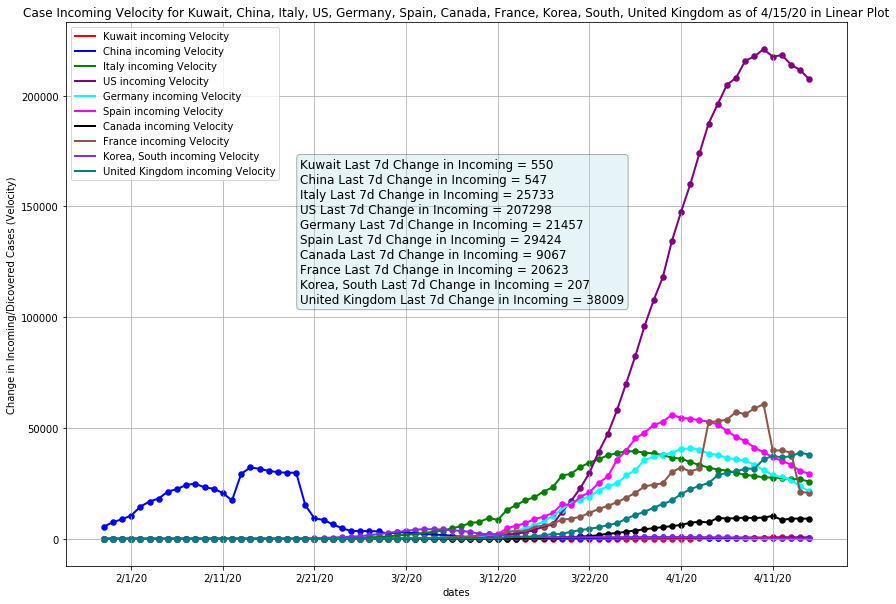

In [400]:
## The multi region Curve

if region not in regions_list:
    regions_list.insert(0, region)
    colors.insert(0, 'red')

list2string = ', '.join([str(elem) for elem in regions_list])
title = 'Case Incoming Velocity for ' + list2string + ' as of ' + str(
    us_df_cumulative.index[-1]) + ' in Linear Plot'
text_strings = []
fig, ax = plt.subplots(figsize=(14, 10))

i = 0

change_period = 7
for r in regions_list:
    colname2 = r + ' incoming Velocity'

    df1 = df_confirmed[df_confirmed['Country/Region'].values == r].copy(
        deep=True)

    df2 = pd.DataFrame(df1[dates].sum(), columns=[colname2])
    df2['dates'] = dates

    df2[colname2] = df2[colname2].diff(change_period)
    df2[colname2].plot(ax=ax, c=colors[i], lw=2, title=title)
    df2.plot.scatter(ax=ax, c=colors[i], x='dates', y=colname2, lw=2)
    text_strings.append(regions_list[i] + ' Last ' + str(change_period) +
                        'd Change in Incoming = ' +
                        str(int(df2[colname2][-1:][0])))
    i = i + 1

textstr = '\n'.join([str(elem) for elem in text_strings])
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.3)
ax.text(0.3,
        0.75,
        textstr,
        transform=ax.transAxes,
        fontsize=12,
        fontfamily='sans-serif',
        verticalalignment='top',
        bbox=props)

plt.ylabel('Change in Incoming/Dicovered Cases (Velocity)')
ax.legend()
ax.grid(True, which="both")
plt.show()

## COVID-19 Acceleration Curve for Multiple Regions

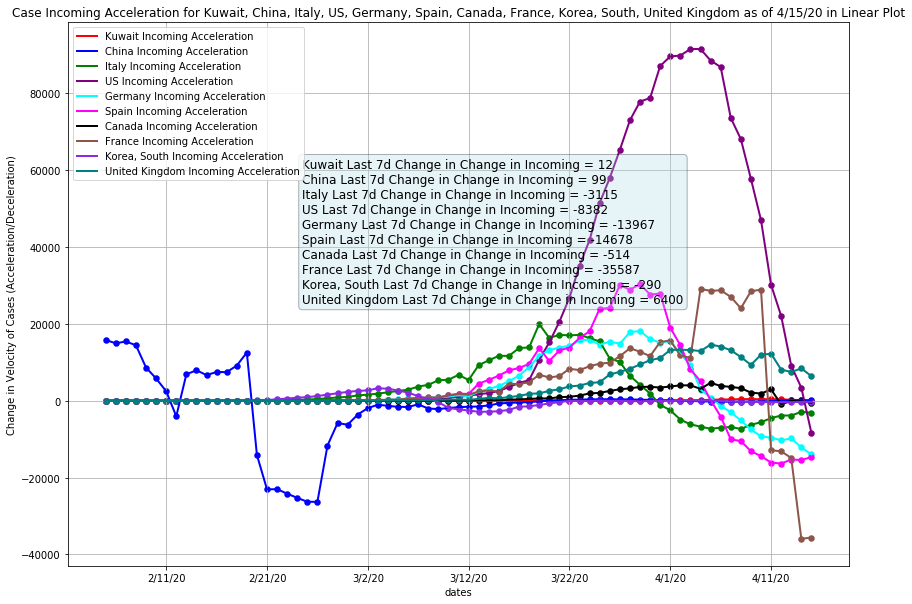

In [401]:
## The multi region Curve
#regions_list = ['China','Italy','US','Korea, South','Spain','Canada','France']
#colors = ['blue','green','purple', 'cyan','magenta','black','#8c564b']  
if region not in regions_list:
    regions_list.insert(0,region)
    colors.insert(0,'red')
    
list2string = ', '.join([str(elem) for elem in regions_list])
title = 'Case Incoming Acceleration for '+ list2string +' as of '+ str(us_df_cumulative.index[-1]) +' in Linear Plot'
text_strings = []
fig, ax = plt.subplots(figsize=(14,10))

i = 0

change_period = 7    
for r in regions_list:
    colname2 = r+' Incoming Acceleration'
    
    df1 = df_confirmed[df_confirmed['Country/Region'].values == r].copy(deep=True)

    df2 = pd.DataFrame(df1[dates].sum(), columns=[colname2])
    df2['dates'] = dates  
    
    df2[colname2] = df2[colname2].diff(change_period).diff(change_period)
    
    df2[colname2].plot(ax=ax,c=colors[i], lw=2, title = title)
    df2.plot.scatter(ax=ax,c=colors[i],x='dates',y=colname2,lw=2)
    text_strings.append(regions_list[i] + ' Last '+str(change_period)+'d Change in Change in Incoming = ' + str(int(df2[colname2][-1:][0])))
    i = i +1    

    
textstr = '\n'.join([str(elem) for elem in text_strings])
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.3)
ax.text(0.3, 0.75, textstr, transform=ax.transAxes, fontsize=12,fontfamily='sans-serif',
        verticalalignment='top', bbox=props)

plt.ylabel('Change in Velocity of Cases (Acceleration/Deceleration)')
ax.legend()
ax.grid(True,which="both")
plt.show()

=>initcell
## Calculate R-naught (Covid-19 Growth) for {{region}}

### Form more info on R-naught, check https://en.wikipedia.org/wiki/Basic_reproduction_number

In [402]:
## ASSUMPTION:
##    1) In early stages of contagion, there is NO limiting factor for the spreading of virus
##    2) Uninficted Population is very close to total population
##    3) Assume Free movement (No lockdowns) of individuals in and out of areas affected by virus
##

us_df_cumulative = pd.DataFrame(usa[dates].sum(), columns=[colname])

## Find Last day's total cases
TotalCasesToDate = us_df_cumulative[colname][-1:][0]

## Create a new Series that calculates the difference from day to day

ChangeFromDay2Next = us_df_cumulative[colname].diff(1)
us_df_cumulative[colname] = us_df_cumulative[
    us_df_cumulative[colname] > 0].copy(deep=True)
us_df_cumulative[colname] = us_df_cumulative[colname].dropna()
ChangeFromDay2NextPercent = us_df_cumulative[colname].pct_change(1)

## Find the Average change from day to day
AverageChangeFromDay2Next = ChangeFromDay2Next.mean()

## Create a series of R0 by calculating the ratio of one day to the day before
r0 = []  # Will record the ratio day to day, start from day 1 to last day
for day in range(1, len(ChangeFromDay2Next)):
    if (ChangeFromDay2Next[day - 1:][0] == 0):  # Avoid dividing by zero
        r0.append(0)
    else:
        r0.append(ChangeFromDay2Next[day:][0] /
                  ChangeFromDay2Next[day - 1:][0])

## Look back 20 days only. This is the most relevant data
GoBackDays = 40
dict0 = {
    'Date': us_df_cumulative.index[-GoBackDays:].values,
    'R-Naught': r0[-GoBackDays:]
}
R_Naught = pd.DataFrame(dict0)
R_Naught = R_Naught.set_index('Date')

#print('ChangeFromDay2Next' , ChangeFromDay2Next[-1:][0])
DailyDelta = ChangeFromDay2Next[-1:][0]

#print(us_df_cumulative['Actual USA COVID-19 Cases'][-2:][0])
DailyDeltaPercent = 100 * DailyDelta / us_df_cumulative[colname][-2:][0]

## {{region}} Covid-19 Status : Descriptive Summary

In [403]:
## Print Status
print('-- This is for region :', region)
print(
    "-- Total cases as of " + str(us_df_cumulative.index[-1:][0]) +
    "(End of day) is " + str(TotalCasesToDate), 'cases')
print("-- Average case count change from one day to next = ",
      np.round(AverageChangeFromDay2Next, 2), ' cases')

print(
    "-- Change in " + region + " confirmed COVID-19 cases FROM",
    str(us_df_cumulative.index[-2:][0]), "TO",
    str(us_df_cumulative.index[-1:][0]) + "(End of day) is " +
    str(int(DailyDelta)), 'cases', "OR " +
    str(np.round(DailyDeltaPercent, 2)) + '% from previous case total. ',
    '\n-- This is', np.round((DailyDelta / AverageChangeFromDay2Next), 2),
    'Times the Average count in daily changes. \n-- The current Average PERCENT(%) change from day to day is',
    str(np.round(100 * ChangeFromDay2NextPercent.mean(), 2)) + '%' +
    ' from previous case total.',
    "This means it's Above or Below (if negative) the average daily % change by "
    + str(np.round(100 * ChangeFromDay2NextPercent.mean(), 2)) + '%')
print("-- R-naught value as of end-of-day",
      str(us_df_cumulative.index[-1:][0]), 'IS',
      np.round(R_Naught['R-Naught'][-1:][0], 4))
print('-- The average R-naught from the past', GoBackDays, 'days is',
      np.round(R_Naught['R-Naught'].mean(), 4))

-- This is for region : Kuwait
-- Total cases as of 4/15/20(End of day) is 1405 cases
-- Average case count change from one day to next =  16.73  cases
-- Change in Kuwait confirmed COVID-19 cases FROM 4/14/20 TO 4/15/20(End of day) is 50 cases OR 3.69% from previous case total.  
-- This is 2.99 Times the Average count in daily changes. 
-- The current Average PERCENT(%) change from day to day is 30.84% from previous case total. This means it's Above or Below (if negative) the average daily % change by 30.84%
-- R-naught value as of end-of-day 4/15/20 IS 0.9091
-- The average R-naught from the past 40 days is 1.1133


=>initcell
## {{region}} R-naught Chart as a Time Series

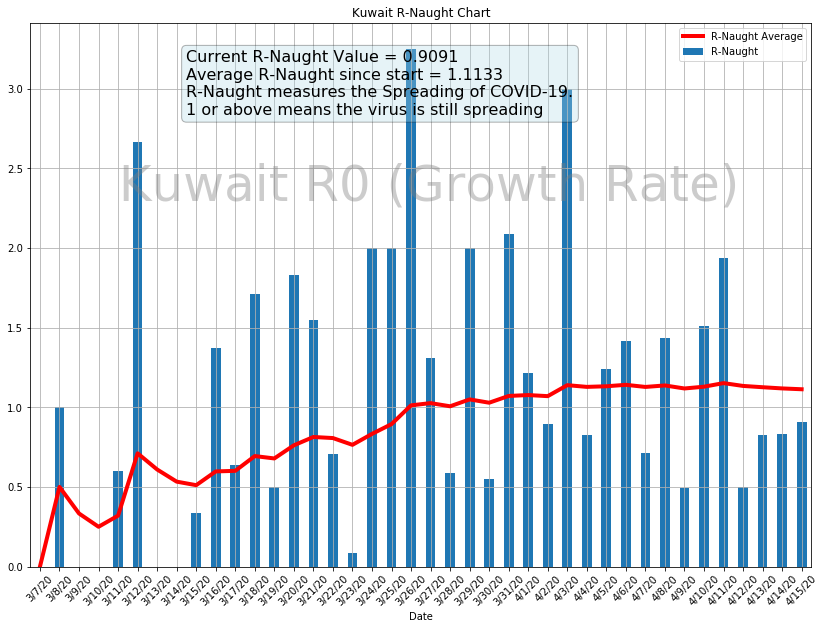

In [404]:
## Plot Growth Curve
fig, ax = plt.subplots(figsize=(14, 10))
ax.grid(True)
R_Naught['R-Naught'].plot(ax=ax, kind='bar', title=region + ' R-Naught Chart')
R_Naught['R-Naught Average'] = R_Naught.expanding().mean()
R_Naught['R-Naught Average'].plot(ax=ax, c='r', grid=True, lw=4)
ax.legend()

textstr = '\n'.join(
    (r'Current R-Naught Value = %.4f' % (R_Naught['R-Naught'][-1:][0], ),
     r'Average R-Naught since start = %.4f' %
     (R_Naught['R-Naught Average'][-1:][0], ),
     r'R-Naught measures the Spreading of COVID-19.',
     r'1 or above means the virus is still spreading'))

props = dict(boxstyle='round', facecolor='lightblue', alpha=0.3)

ax.text(0.5,
        0.7,
        ' '+region + ' R0 (Growth Rate)',
        horizontalalignment='center',
        color='gray',
        fontsize=50,
        alpha=0.4,
        verticalalignment='center',
        transform=ax.transAxes)

ax.text(0.2,
        0.95,
        textstr,
        transform=ax.transAxes,
        fontsize=16,
        verticalalignment='top',
        bbox=props,
        fontfamily='sans-serif')

_ = plt.xticks(rotation=45)
plt.show()

In [405]:
## Find out the full path to 'jupyter' and update the line below with the path
!/home/sabawi/anaconda3/bin/jupyter nbconvert covid-19-r-naught.ipynb --no-input

[NbConvertApp] Converting notebook covid-19-r-naught.ipynb to html
[NbConvertApp] Writing 1905137 bytes to covid-19-r-naught.html
